<a href="https://colab.research.google.com/github/HariShankar08/JupyterNotebooks/blob/main/Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr
import fix_yahoo_finance

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ticker = pdr.get_data_yahoo('AAPL', start=dt.datetime(2020, 1, 1), end=dt.date.today())

ticker.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,73.840042
2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.122154
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,73.704819
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.358185
2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,74.538239


In [ ]:
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=ticker.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ticker['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ticker['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

In [ ]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ticker['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ticker['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ticker['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

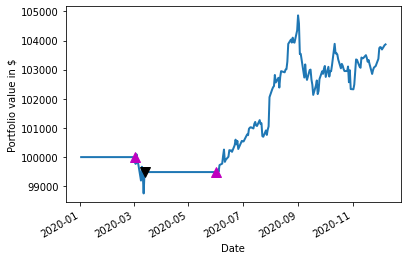

In [ ]:

import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

### wait whaa